# Homework 2: Evaluating Paired Functions
*Sean Steinle*

### Contents
0. [Imports, Data Loading](#Imports,-Data-Loading)
1. [Preprocessing F and G](#Preprocessing-F-and-G)
2. [Error Metrics for F and G](#Error-Metrics-for-F-and-G)
3. [Visualizing a Specific Set of Betas](#Visualizing-a-Specific-Set-of-Betas)

## Imports, Data Loading

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp

In [2]:
path = "data/homework_02-data.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,subject,x,f,g
0,1,0.000,-1.171990,-0.342031
1,1,0.001,-1.082194,-0.327248
2,1,0.002,-0.952844,-0.297205
3,1,0.003,-0.793758,-0.263112
4,1,0.004,-0.614753,-0.226987


## Preprocessing F and G

In [50]:
#helper functions for the main preprocessing function. simple, mainly for abstraction/readability
def scale(x: float, l: float, h: float):
    """Scale value between the minimum, l, and maximum, h.
    Pass in l and h so we don't need to recalculate min and max so often.
    Inspired by: https://stackoverflow.com/questions/18380419/normalization-to-bring-in-the-range-of-0-1
    """
    return (x-l)/(h-l)

def warp(x: int, B: tuple):
    """Warp function that partially defines f and g."""
    b1, b2, b3 = B
    return (exp(b1)*x + exp(b2)*x**exp(b3))/(exp(b1)+exp(b2))

In [104]:
#the core preprocessing function
def preprocess(subject: int, data: pd.DataFrame):
    """Preprocesses data by selecting subject i from the data, scaling f_i and g_i to [0,1], and returning a
    function to evaluate f(x) and g(x_tilde).
    Returns a function that will evaluate f and g at many x for a given tuple of betas.
    """
    #select subject data
    subject_df = df[df["subject"] == subject]
    
    #expand x as int
    x_int = subject_df["x"].map(lambda x: int(x*1000))
    
    #scale function values to [0,1]
    F = subject_df["f"]
    l = np.min(F)
    h = np.max(F)
    f_scaled = F.map(lambda f: scale(f, l, h)).tolist()

    #now scale g
    G = subject_df["g"]
    l = np.min(G)
    h = np.max(G)
    g_scaled = G.map(lambda g: scale(g, l, h)).tolist()
    
    def preprocessor(betas: tuple):
        """This function is returned from the larger preprocess function. 
        It returns scaled f values and scaled and warped g values.
        """
        if len(betas) != 3:
            raise ValueError("You must specify exactly 3 betas to estimate g.")

        G = [warp(g_scaled[x],betas) for x in x_int]
        
        return f_scaled,G #returns scaled, evaluated f and g
        
    return preprocessor

**Testing Our Function Factory**

To test that our function factory is working correctly, we can perform a few quick tests:
1. We can evaluate G for the beta set (1,100,0). This set of betas essentially turns the warp function into an identity function (as B2 trends towards infinity). We can see this phenomenon by plotting our scaled f and scaled and warped g values against each other. They are nearly identical.
2. We can evaluate F and G for all samples (from 1:150) without error.
3. We should ensure if we pass more or less than 3 betas, there is an informative error.

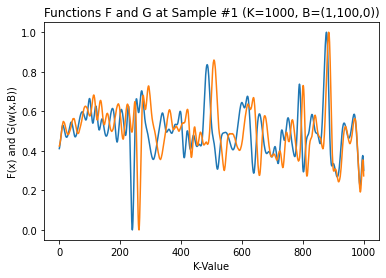

In [212]:
#Test 1: specify g to be an identity function

#generate values for f and g for candidate 1 with identity-value betas
sample1_preprocessor = preprocess(1,df)
f,g = sample1_preprocessor((1,100,0))

#plot f and g
plt.plot(range(0,1001,1),f)
plt.plot(range(0,1001,1),g)
plt.title("Functions F and G at Sample #1 (K=1000, B=(1,100,0))")
plt.xlabel("K-Value")
plt.ylabel("F(x) and G(w(x,B))")
plt.savefig("plots/identify_plot.png")

In [106]:
#Test 2: We can evaluate F and G for all samples i
preprocessors = [preprocess(i,df) for i in range(1,151,1)]
function_pairs = [p((1,100,0)) for p in preprocessors]
F,G = function_pairs[0] #for sample 1
assert len(F) == 1001
assert len(G) == 1001

In [204]:
#Test 3: More or less than 3 betas raises error
p = preprocess(1,df)
try:
    f,g = p((1,100))
except ValueError as e:
    print(f"caught error: {e}")

caught error: You must specify exactly 3 betas to estimate g.


## Error Metrics for F and G

Question: Shouldn't we be passing in the dataset into this function? It doesn't say to do this in the instructions, but otherwise we are referencing a global dataframe that is just floating around in the namespace within a function!

In [195]:
def huber_rho(t: float, c: float):
    """Helper function for huber_metric which calculates the rho value."""
    if abs(t) <= c:
        return (t**2)/2
    else:
        return c*(abs(t)-(c/2))

def tukey_rho(t: float, c: float):
    """Helper function for tukey_metric which calculates the rho value."""
    if abs(t) <= c:
        return 1-((1-(t/c)**2)**3)
    else:
        return 1

def calculate_error(B: tuple, preprocess_function, error_metric: str, c: float):
    """Main function used to calculate 3 different error types: L2, Huber, and Tukey.
    """
    errors = []
    function_pairs = [preprocess_function(sample_i,df)(B) for sample_i in range(1,151,1)] #evaluate F,G wrt this set of betas for each candidate
    for sample_i,(F,G) in enumerate(function_pairs): #now consider each sample
        if error_metric == "l2":
            error = sum([(F[x]-G[x])**2 for x in range(len(F))]) #calculate the l2 loss at each point, sum
        elif error_metric == "huber":
            error = sum([huber_rho((F[x]-G[x]),c) for x in range(len(F))]) #calculate the huber loss at each point, sum
        elif error_metric == "tukey":
            error = sum([tukey_rho((F[x]-G[x]),c) for x in range(len(F))]) #calculate the tukey loss at each point, sum
        else:
            raise ValueError(f"{error_metric} is not a supported metric type. Try l2, huber, or tukey.")
        errors.append(error) #append this sample's total error to the list of error
    return errors

**Testing Our Error Metrics**

Let's perform a few more tests to ensure our error metrics are implemented correctly:
1. We should be able to evaluate one beta set for each metric type without error.
2. We should be able to evaluate multiple beta sets for each metric without error.
3. We should ensure if we pass an incorrect error type, there is an informative error.

In [199]:
#Test 1: calculate errors for one set of betas with each metric type
errors = [calculate_error((1,500,0), preprocess, metric_type, 1) for metric_type in ["l2","huber","tukey"]]

In [206]:
#Test 2: calculate errors for each metric type with different sets of betas
errors = [calculate_error(beta, preprocess, metric_type, 1) for metric_type in ["l2","huber","tukey"] for beta in [(1,100,0),(1,500,0)]]

In [203]:
#Test 3: throw error on unsupported error type
try:
    calculate_error((1,500,0), preprocess, "seans_favorite_error", 1)
except ValueError as e:
    print(f"caught error: {e}")

caught error: seans_favorite_error is not a supported metric type. Try l2, huber, or tukey.


## Visualizing a Specific Set of Betas

In [210]:
betas = (2,1.5,0.2)
l2,huber,tukey = [calculate_error(betas, preprocess, metric_type, 0.1) for metric_type in ["l2","huber","tukey"]]

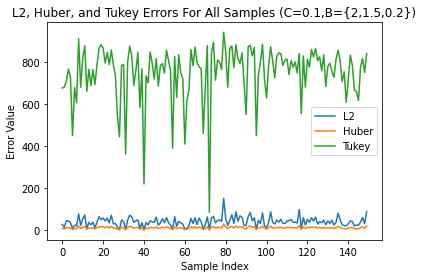

<Figure size 432x288 with 0 Axes>

In [231]:
plt.plot(range(0,150,1),l2,label = "L2")
plt.plot(range(0,150,1),huber,label = "Huber")
plt.plot(range(0,150,1),tukey,label = "Tukey")
plt.title("L2, Huber, and Tukey Errors For All Samples (C=0.1,B={2,1.5,0.2})")
plt.xlabel("Sample Index")
plt.ylabel("Error Value")
plt.legend()
plt.show()
plt.savefig("plots/all_errors.png")

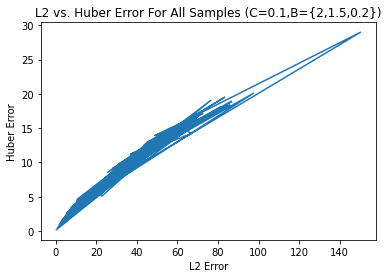

<Figure size 432x288 with 0 Axes>

In [223]:
plt.plot(l2,huber)
plt.title("L2 vs. Huber Error For All Samples (C=0.1,B={2,1.5,0.2})")
plt.xlabel("L2 Error")
plt.ylabel("Huber Error")
plt.show()
plt.savefig("plots/l2_vs_huber.png")

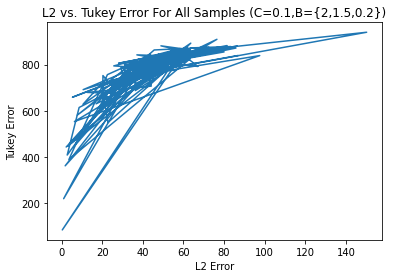

<Figure size 432x288 with 0 Axes>

In [224]:
plt.plot(l2,tukey)
plt.title("L2 vs. Tukey Error For All Samples (C=0.1,B={2,1.5,0.2})")
plt.xlabel("L2 Error")
plt.ylabel("Tukey Error")
plt.show()
plt.savefig("plots/l2_vs_tukey.png")

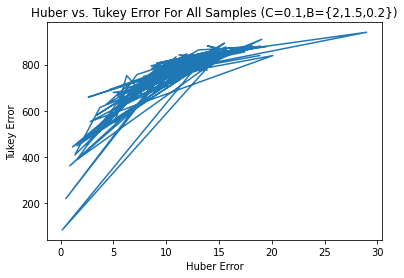

<Figure size 432x288 with 0 Axes>

In [225]:
plt.plot(huber,tukey)
plt.title("Huber vs. Tukey Error For All Samples (C=0.1,B={2,1.5,0.2})")
plt.xlabel("Huber Error")
plt.ylabel("Tukey Error")
plt.show()
plt.savefig("plots/huber_vs_tukey.png")

At first glance, it looks like all metrics agree on the relative distribution of error between f and g. That said, L2 and Huber are scaled much smaller than Tukey at this value of the betas and cutoff. More exploration is needed for other beta and cutoff values, as well as more background research on the Huber and Tukey error metrics.